# Crop Yield in the Sahel 
The crop production, e.g. maize and millet, in the Sahel region depends on the precipitations, the air temperature, in particular temperature values above 30°C, and the use of fertilizers such as nitrogen and manure. It may also depend on the increase of CO2 in the air. In this notebook, since the dataset is small, we model the dependency of the crop production on the said variables using a neural network with only one hidden layer. This choise is based on the fact that [it has been proven](https://en.wikipedia.org/wiki/Universal_approximation_theorem) that a neural network with only one hidden layer, with an arbitrary number of units, can approximate any function. The problem can be classified as a regression problem where the relationship between the input variables and the dependent variable is non-linear. We start by reading the data from different countries in the Sahel region. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

numpy version: 1.25.2
pandas version: 2.1.1
matplotlib version: 3.8.0


## The dataset
The dataset that we will use in this notebook contains the annual production of two crops, maize and millet, in some countries in the Sahel region from 1980 up to 2010.

In [3]:
crop_yield_df = pd.read_csv('data/crop_yields_sahel.csv')
print('Number of records for Sahel: {0:d}'.format(len(crop_yield_df)))

Number of records for Sahel: 202


In [4]:
crop_yield_df[:3]

,Year,Area,pcp,tmp,tmp30sr,mean CO2,unc CO2,N [kg/ha],P2O5 [kg/ha],K2O [kg/ha],Manure applied to Soils [kg/ha],N + Manure [kg/ha],Maize [hg/ha],Millet [hg/ha]
0,1980,Burkina Faso,79.903095,26.477923,584.412288,338.76,0.12,0.45,0.69,0.41,3.2465,3.6965,9029,4871
1,1981,Burkina Faso,91.976429,25.869713,514.558300,340.12,0.12,1.08,1.55,0.84,3.6697,4.7497,8297,4801
2,1982,Burkina Faso,49.251481,27.276417,834.173411,341.48,0.12,1.15,1.59,0.87,3.9769,5.1269,8235,4853


## How to look at the data
When we try to build a model from a dataset we have to understand what kind of relationship exists between the independent variables, in our case precipitation, temperature and others, and the dependent ones that is the yield of maize and millet. We might think that the production of maize (m) does not depend on the year (t), it only depends on the (mean yearly) precipitations (p), mean temperature (T) , and the amount of fertilizers (N), that is

$$m = f(p, T, N)$$

We also assume, as a simplifying assumption, that the variable p and T are indipendent, even if that is not really the case. In this case we want to find a function $\hat{m}$ that can approximate the real unknown one using the data. Since we do not include the time, the model once available could be used to predict the production of maize at any year depending on the amount of precipitation, temperature, and fertilizer. The input data to train our model would be a matrix of examples [p, T, N, Maize] and there would be no need to take into account the order of the rows. A neural network would have three inputs and one output. 

![Neural Network](images/neural_network.jpg)

We can imagine the function f(p,T,N) as a surface in a 4-dimensional space. As a second hypothesis, we might think that there is a dependency of the production of maize on the year since at least p, T and N depend on it. In this case the dependency looks like

$$m = f(p(t), T(t), N(t), t)$$

The function can be seen like a line in a 5-dimensional space. The example data can be represented as matrix [y, p, T, N, Maize]. Also in this case we do not need to consider the order of the rows. Our neural network would have 4 inputs and one output. 

![Neural Network](images/neural_network_4_inputs.jpg)

Finally, we might think that the production of maize not only depends on the year but also on the yield of the previous year or even on the two previous years. For instance the land might have less nutrients after the previous yield. In this last case the function can still be seen like a line in a 5-dimensional space but it will look different from the previous one if our assumption about its dependency on the past holds and we would have to consider the order of the rows.

## The neural network model
The model is based on a small neural network with an input layer for the meteo-climatic data and the fertilizers, an hidden layer to model the relationships among the predictors and the dependency of the yield of maize and millet, the target variables, from them. The predictors chosen for the yield of maize and millet in the Sahel region are

* Annual mean temperature (in °C)
* Number of hours with temperature > 30°C during the growing season per year
* Annual total precipitation (in mm)
* Atmospheric $CO_2$ concentration (in ppm, only for millet)
* Sum of annual amount of chemical fertilizer (nitrogen + manure, kg per hectares)

The cost function contains a momentum regularization. In order to reduce the variability due to the initial random choice of the parameter values, the model is run several times with different weights initialization values as in an ensemble technique and the mean value of the ensemble is used for the yield. In the paper 20 models with the same architecture but different weight initialization values are used as members of an ensemble. The training is performed using the k-fold cross-validation technique for which k examples are removed from the examples and used as a test set. In our case k=n so that only one example is used as test for each epoch (leave-one-out). A validation test is performed using a subset of the example set. The training process is  stopped as soon as the error increases (early stopping).      

* Model: neural network with one hidden layer using the tanh activation function (see [scikit-learn Multi-layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [PyTorch](https://pytorch.org/))
* Cost function: quadratic loss (or mean squared error) with momentum regularization
* Training procedure: [leave-one-out](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo) cross validation (one example used for test, a subset (10% random examples) used for validation and the rest for training) with [early stopping](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html)
* Optimization algorithm: stochastic gradient descent (fixed learning rate) or Quasi-Newton BFGS (see scikit-learn Multi-layer Perceptron [algorithms](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#algorithms))  
* Hyper-parameters optimization (e.g. [Grid Search, or randomized search](https://scikit-learn.org/stable/modules/grid_search.html))
* Data pre-processing: mean normalization 
* [Ensemble method](https://scikit-learn.org/stable/modules/ensemble.html): neural network models with different weights initialization and validation set by setting different random seeds (bootstrap replicates: sampling with replacement from the training dataset after the test set has been selected)


We create an MLP with one hidden layer to approximate a function that represents the yield of a crop (maize or millet) depending on the yearly values of precipitation, temperature, number of hours with temperatures above 30°C, amount of nitrogen fertilizer, and amount of manure fertilizer. We use a 4-5-1 architecture. We can compute the preactivation of the hidden layer by a matrix multiplications between the units of the input layer and the units of the hidden layer.

$$z_h = W_{xh}x + b_h$$

The output of the hidden layer is then computed by applying an activation function $\sigma_h$ to the result of the preactivations

$$a_h = \sigma_h (W_{xh}x + b_h)$$

The output of the neural network is computed in the same way by a matrix multiplication between the units of the hidden layer and the output unit. Considering the bias for each unit, the number of paramenters (weights) for a 4-5-1 neural network is 31.

A loss function, such as Mean Squared Error (MSE), may include a penalty term such as momentum, L2 or L1 regularization terms

$$ℒ = \frac{1}{2}||y(x, w) - y^*(x)||^2 + \lambda ||w||^2$$

The loss function with weight decay using L2 regularization (not to be used with early stopping)

$$w_{i+1} = w_i - γ∇_wℒ$$

## K-fold cross-validation and ensemble method
The methodology can be described algorithmically. For k-fold cross-validation see Raschka ch.6, p.177. The same procedure is used for the two ensembles, one for maize model (4 input units, 5 hidden, 1 output) and one for millet model (5 input units, 5 hidden, 1 output). The execution of the estimators from the bootstrap samples can be done in [parallel](https://scikit-learn.org/stable/computing/parallelism.html) on a multicore CPU.


````
N = 202 # number of records
K = N # folds for validation (leave-one-out cross-validation)
E = 20 # number of ensemble members

# Hyper parameters setting
V = 15 # size of the validation set
M = 5000 # number of epochs (training cycles using all the records in the training set) 
m = 0.6 # momentum, only used with stochastic or mini-batch gradient descent optimization
l = 0.35 # learning rate

model_maize[E] = array[E]
model_maize_val[K] = array[K]

# Training procedure
for ensemble in range(0, E): 
  init_weights(model_maize[ensemble])
  for fold in range(0, K):
    dataset = dataset - record[fold]
    val_set = select_val_set(dataset)
    train_set = dataset - val_set
    for epoch in range(0, M):
      train_model(model_maize_val[fold], train_set) 
      val_model(model_maize_val[fold], val_set) # apply early stopping when validation error increases
  best_model_maize = select_model(model_maize_val)      
  model_maize[ensemble] = best_model_maize

# Inference procedure: we sample the models in the ensemble to compute the yield for each pattern in the original dataset
# for each country and for each year
sum_model_out[N] = array[N]
for test in range(0, N):
  sum_model_out[test] = 0
  for ensemble in range(0, E):
    model_output[test] = model_maize[ensemble](test)
    sum_model_out[test] = sum_model_out[test] + model_output[test]
  sum_model_out[test] = sum_model_out[test] / E
````

## scikit-learn
Scikit-Learn is an open source machine learning Python package that implements several algorithms for classification and regression tasks. The API is based on classes that allow the user to choose classification and optimization algorithms, transformations for data pre-processing and constructs to build processing workflows. The scikit-learn library with other Python packages such as Pandas, NumPy, and Matplotlib, provide all the components required for this project. 

## Burkina Faso

In [5]:
year_index_bf = pd.Series(pd.date_range('1980', periods=31, freq="Y")).dt.year
year_index_bf[:3]

0    1980
1    1981
2    1982
dtype: int32

We select the records for Burkina Faso

In [6]:
crop_yield_bf_df = crop_yield_df[crop_yield_df['Area'] == 'Burkina Faso']
print('Number of records for Burkina Faso: {0:d}'.format(len(crop_yield_bf_df)))

Number of records for Burkina Faso: 31


In [7]:
crop_yield_bf_df.drop(['Year'], axis=1, inplace=True)
crop_yield_bf_df = crop_yield_bf_df.set_index(year_index_bf)
crop_yield_bf_df[:3]

,Area,pcp,tmp,tmp30sr,mean CO2,unc CO2,N [kg/ha],P2O5 [kg/ha],K2O [kg/ha],Manure applied to Soils [kg/ha],N + Manure [kg/ha],Maize [hg/ha],Millet [hg/ha]
1980,Burkina Faso,79.903095,26.477923,584.412288,338.76,0.12,0.45,0.69,0.41,3.2465,3.6965,9029,4871
1981,Burkina Faso,91.976429,25.869713,514.558300,340.12,0.12,1.08,1.55,0.84,3.6697,4.7497,8297,4801
1982,Burkina Faso,49.251481,27.276417,834.173411,341.48,0.12,1.15,1.59,0.87,3.9769,5.1269,8235,4853


We plot the yield data for maize and millet

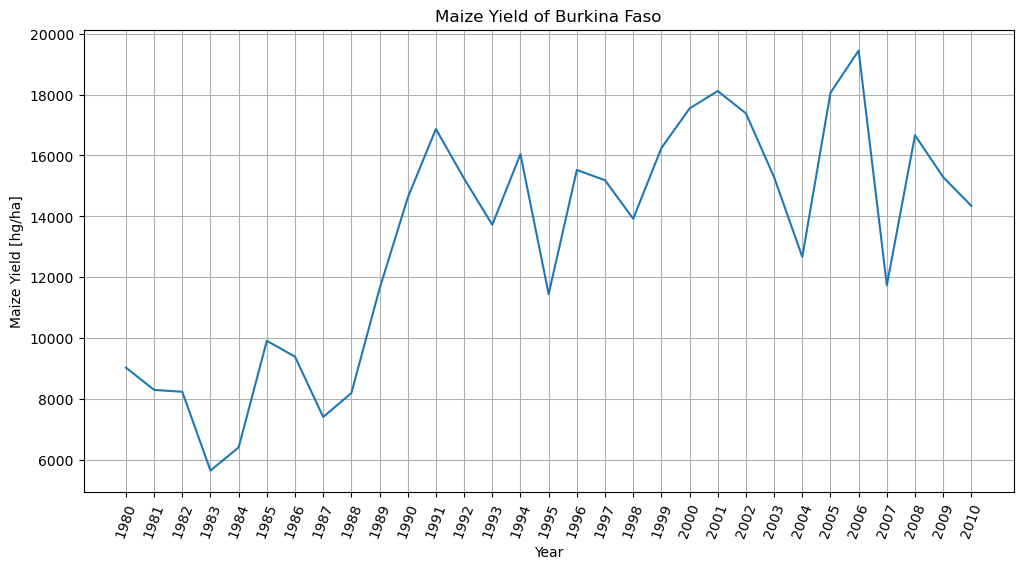

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield of Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Maize Yield [hg/ha]');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['Maize [hg/ha]'])

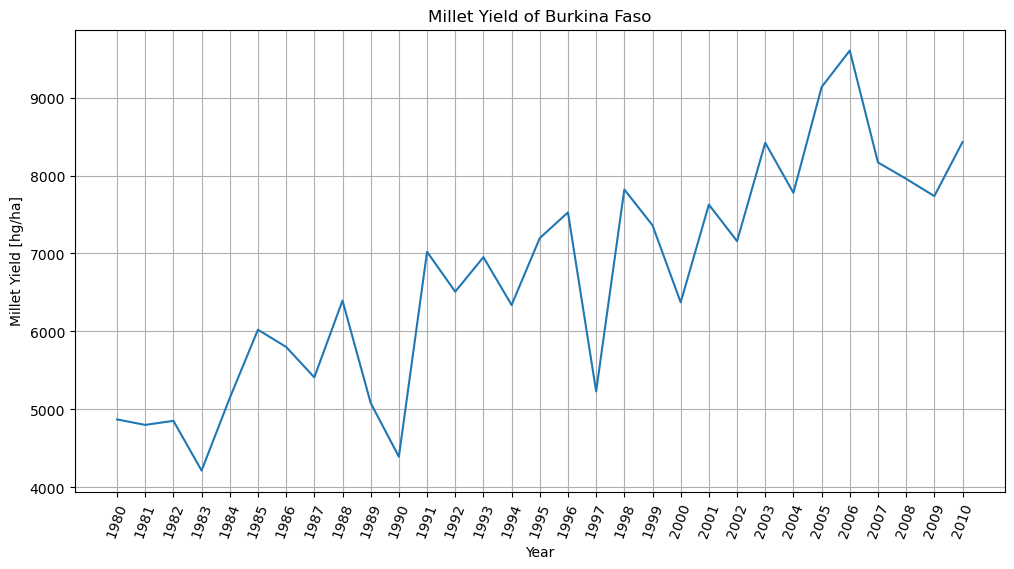

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Millet Yield of Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Millet Yield [hg/ha]');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['Millet [hg/ha]'])

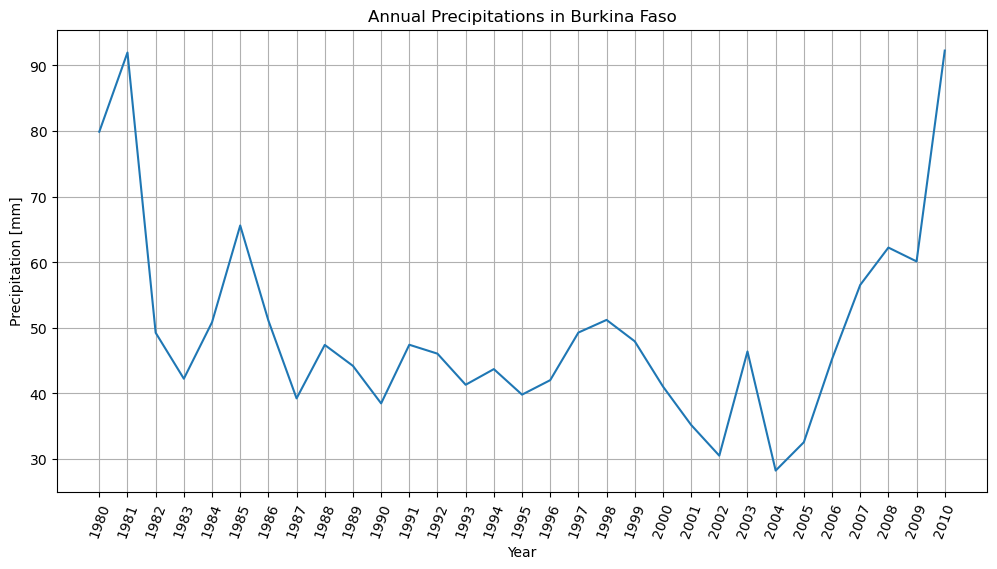

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Annual Precipitations in Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation [mm]');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['pcp'])

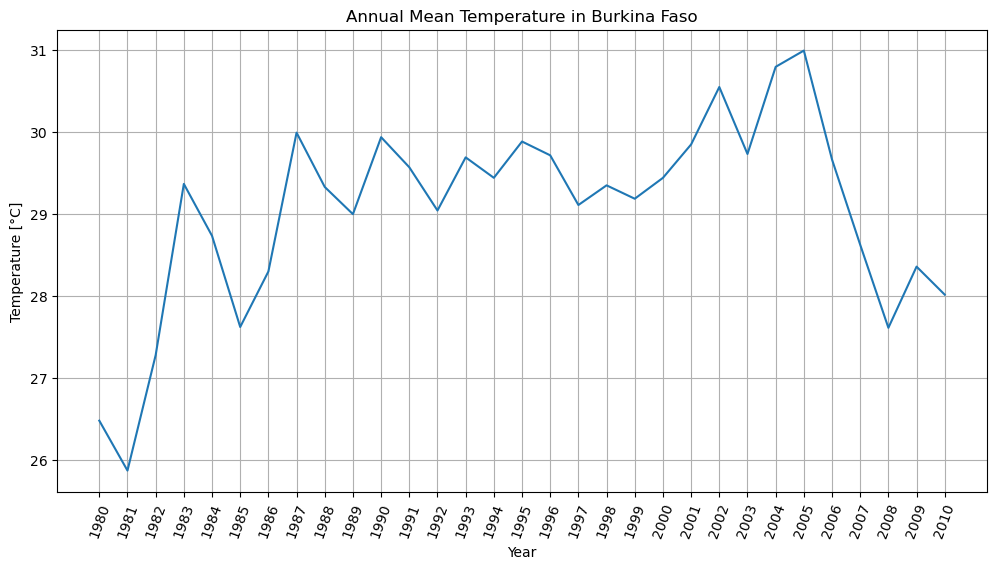

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Annual Mean Temperature in Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature [°C]');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['tmp'])

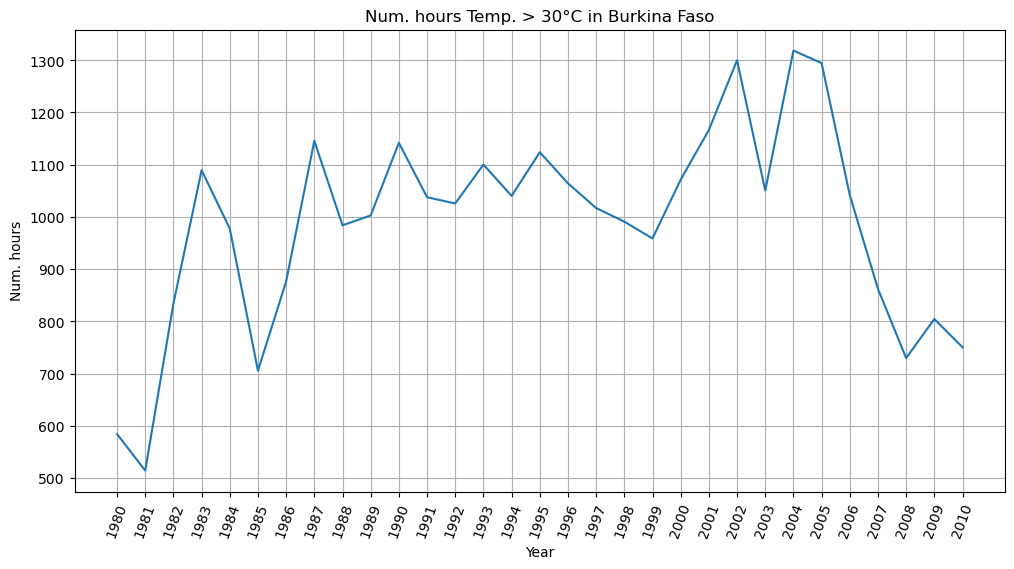

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Num. hours Temp. > 30°C in Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Num. hours');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['tmp30sr'])

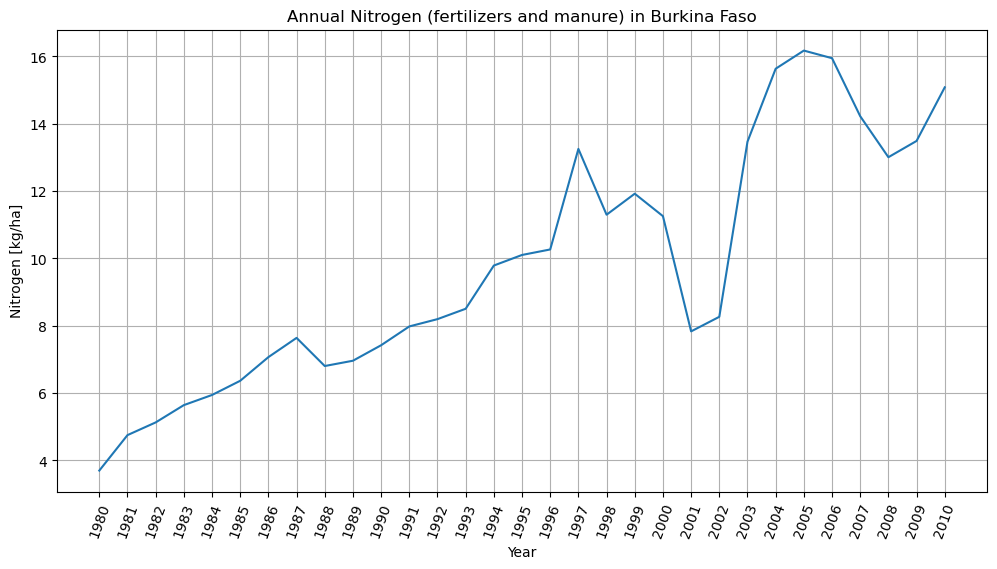

In [13]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Annual Nitrogen (fertilizers and manure) in Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Nitrogen [kg/ha]');
ax.set_xticks(crop_yield_bf_df.index)
ax.set_xticklabels(crop_yield_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yield_bf_df['N + Manure [kg/ha]'])

In [14]:
N = crop_yield_bf_df.shape[0]
mean_maize_bf = crop_yield_bf_df['Maize [hg/ha]'].sum() / N
print('Mean maize yield for Burkina Faso [hg/ha]: {0:.2f}'.format(mean_maize_bf))

Mean maize yield for Burkina Faso [hg/ha]: 13207.90


We normalize the data about the maize yield for Burkina Faso

In [15]:
max_maize_bf = crop_yield_bf_df['Maize [hg/ha]'].max() * 1.0
maize_yield_bf_norm_df = (crop_yield_bf_df['Maize [hg/ha]'] / max_maize_bf - 0.5) * 2
maize_yield_bf_norm_df[:3]

1980   -0.071282
1981   -0.146575
1982   -0.152952
Name: Maize [hg/ha], dtype: float64

In [16]:
mean_millet_bf = crop_yield_bf_df['Millet [hg/ha]'].sum() / N
print('Mean millet yield for Burkina Faso [hg/ha]: {0:.2f}'.format(mean_millet_bf))

Mean millet yield for Burkina Faso [hg/ha]: 6688.29


In [17]:
mean_precipitation_bf = crop_yield_bf_df['pcp'].sum() / N
print('Mean annual precipitation for Burkina Faso: {0:.2f} mm'.format(mean_precipitation_bf))

Mean annual precipitation for Burkina Faso: 49.66 mm


In [18]:
mean_temperature_bf = crop_yield_bf_df['tmp'].sum() / N
print('Mean annual temperature for Burkina Faso: {0:.2f} °C'.format(mean_temperature_bf))

Mean annual temperature for Burkina Faso: 29.05 °C


We normalize the data about the millet yield for Burkina Faso

In [19]:
max_millet_bf = crop_yield_bf_df['Millet [hg/ha]'].max() * 1.0
millet_yield_bf_norm_df = (crop_yield_bf_df['Millet [hg/ha]'] / max_millet_bf - 0.5) * 2
millet_yield_bf_norm_df[:3]

1980    0.014475
1981   -0.000104
1982    0.010726
Name: Millet [hg/ha], dtype: float64

## Data pre-processing
We normalize the yield data of the full dataset to be within the range [-1, 1]

### Manual standardization
We normalize the data by computing the mean and the maximum value of the features used for training

In [20]:
N = crop_yield_df.shape[0]
max_millet = crop_yield_df['Millet [hg/ha]'].max() * 1.0
mean_millet = crop_yield_df['Millet [hg/ha]'].sum() / N
print('Mean millet yield [hg/ha]: {0:.2f}\nMax millet yield [hg/ha]: {1:.2f}'.format(mean_millet, max_millet))

Mean millet yield [hg/ha]: 7536.59
Max millet yield [hg/ha]: 18483.00


In [21]:
max_maize = crop_yield_df['Maize [hg/ha]'].max() * 1.0
mean_maize = crop_yield_df['Maize [hg/ha]'].sum() / N
print('Mean maize yield [hg/ha]: {0:.2f}\nMax maize yield [hg/ha]: {1:.2f}'.format(mean_maize, max_maize))

Mean maize yield [hg/ha]: 12023.10
Max maize yield [hg/ha]: 33349.00


In [22]:
max_precipitation = crop_yield_df['pcp'].max() * 1.0
mean_precipitation = crop_yield_df['pcp'].sum() / N
print('Mean annual precipitation [mm]: {0:.2f}\nMax annual precipitation [mm]: {1:.2f}'.format(mean_precipitation, max_precipitation))

Mean annual precipitation [mm]: 61.63
Max annual precipitation [mm]: 180.37


In [23]:
max_temperature = crop_yield_df['tmp'].max() * 1.0
mean_temperature = crop_yield_df['tmp'].sum() / N
print('Mean annual temperature [°C]: {0:.2f}\nMax annual temperature [°C]: {1:.2f}'.format(mean_temperature, max_temperature))

Mean annual temperature [°C]: 28.08
Max annual temperature [°C]: 31.28


In [24]:
max_hours30 = crop_yield_df['tmp30sr'].max() * 1.0
mean_hours30 = crop_yield_df['tmp30sr'].sum() / N
print('Mean num. hours temperature > 30 °C: {0:.2f}\nMax num. hours temperature > 30 °C: {1:.2f}'.format(mean_hours30, max_hours30))

Mean num. hours temperature > 30 °C: 666.40
Max num. hours temperature > 30 °C: 1459.46


In [25]:
max_fertilizer = crop_yield_df['N + Manure [kg/ha]'].max() * 1.0
mean_fertilizer = crop_yield_df['N + Manure [kg/ha]'].sum() / N
print('Mean fertilizer [hg/ha]: {0:.2f}\nMax fertilizer [hg/ha]: {1:.2f}'.format(mean_fertilizer, max_fertilizer))

Mean fertilizer [hg/ha]: 7.47
Max fertilizer [hg/ha]: 21.53


In [26]:
data_df = pd.DataFrame({'Millet': crop_yield_df['Millet [hg/ha]'], 
                          'Maize': crop_yield_df['Maize [hg/ha]'], 
                          'Precipitation': crop_yield_df['pcp'],
                         'Temperature': crop_yield_df['tmp'],
                         'Hours30': crop_yield_df['tmp30sr'],
                         'Fertilizer': crop_yield_df['N + Manure [kg/ha]']})
data_df

,Millet,Maize,Precipitation,Temperature,Hours30,Fertilizer
0,4871,9029,79.903095,26.477923,584.412288,3.6965
1,4801,8297,91.976429,25.869713,514.558300,4.7497
2,4853,8235,49.251481,27.276417,834.173411,5.1269
3,4215,5647,42.243907,29.362634,1089.603967,5.6409
4,5147,6408,50.847685,28.729993,977.744567,5.9420
...,...,...,...,...,...,...
197,6606,13919,51.008333,27.481197,655.663850,5.5154
198,4642,11008,47.828833,27.336183,562.751622,5.6062
199,7675,18351,58.559870,27.441293,526.834228,4.6843
200,7703,16300,52.647785,27.118699,639.256848,8.8868


In [27]:
millet_yield_norm_df = (crop_yield_df['Millet [hg/ha]'] / max_millet - 0.5) * 2
maize_yield_norm_df = (crop_yield_df['Maize [hg/ha]'] / max_maize - 0.5) * 2
precipitation_norm_df = (crop_yield_df['pcp'] / max_precipitation - 0.5) * 2
temperature_norm_df = (crop_yield_df['tmp'] / max_temperature - 0.5) * 2
hours30_norm_df = (crop_yield_df['tmp30sr'] / max_hours30 - 0.5) * 2
fertilizer_norm_df = (crop_yield_df['N + Manure [kg/ha]'] / max_fertilizer - 0.5) * 2

In [28]:
data_norm_df = pd.DataFrame({'Millet': millet_yield_norm_df, 
                          'Maize': maize_yield_norm_df, 
                          'Precipitation': precipitation_norm_df,
                          'Temperature': temperature_norm_df,
                          'Hours30': hours30_norm_df,
                          'Fertilizer': fertilizer_norm_df})
data_norm_df.head(3)

,Millet,Maize,Precipitation,Temperature,Hours30,Fertilizer
0,-0.472921,-0.458514,-0.113997,0.692868,-0.199137,-0.656619
1,-0.480496,-0.502414,0.019878,0.653982,-0.294863,-0.558783
2,-0.474869,-0.506132,-0.453877,0.743920,0.143128,-0.523744


### Scikit-Learn standardization
We can also use the [pre-processing](https://scikit-learn.org/stable/modules/preprocessing.html) utility functions provided in scikit-learn to standardize the data  

In [29]:
min = data_df.min(axis=0)
max = data_df.max(axis=0)
X_std = (data_df - min) / (max - min)
X_scaled = X_std * (max - min) + min
#X_scaled
min, max

(Millet           1072.000000
 Maize            2076.000000
 Precipitation      12.758682
 Temperature        24.731735
 Hours30             4.575154
 Fertilizer          0.952300
 dtype: float64,
 Millet           18483.000000
 Maize            33349.000000
 Precipitation      180.367575
 Temperature         31.281738
 Hours30           1459.457044
 Fertilizer          21.530000
 dtype: float64)

In [30]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_df)

We select the data to train a model for the maize yield so the input data will be (from column 2 to 5): precipitation, temperature, temperature above 30°C, total fertilizers, while the output data is the maize yield (column 1).

In [31]:
#data_norm = scaler.transform(data_df)
X = data_norm_df.iloc[:, [2, 3, 4, 5]].to_numpy()
y = data_norm_df.iloc[:, [1]].to_numpy()

## Train and test set
The dataset for the maize is divided into a train and a test set using the scikit-learn train_test_split() function.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, y_train.shape

((181, 4), (181, 1))

## Cross-validation
The train set is then used with cross-validation (k-fold) so that all the data is used for the learning phase. The training set is split in k subsets, k-1 for training and 1 subset for validation. The performance of the k models is evaluated and stored and the best one is selected.  

## Multi-layer perceptron
We use a Multi-layer perceptron as model (see scikit-learn [example](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html)) and compute the [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) error to measure the proportion of variance in the data (e.g. the maize yield variance) explained by the model according to the formula

$$R^2 = \frac{V(\hat{y})}{V(y)}$$

and

$$V(y) = \frac{1}{N-1}\sum_{n=1}^N (y_n - \bar{y})^2$$

where $V(\hat{y})$ is the variance of the model's predictions and V(y) is the variance of the data.

In [33]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, 200) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

In [34]:
ensemble_members = np.zeros((N,num_ensemble_members))
ensemble_members.shape

(202, 20)

We create an ensemble of [MLP models](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), starting with a different random initialization and training them by randomly sampling the train, validation and test sets. 

In [35]:
from time import time

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(5, ),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs'
            )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X)
    ensemble_members[:, i] = model_sample
    print('Ensemble {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}\n")

Ensemble 0
done in 0.130s
Train R2 score: 0.53
Test R2 score: 0.53

Ensemble 1
done in 0.102s
Train R2 score: 0.56
Test R2 score: 0.17

Ensemble 2
done in 0.068s
Train R2 score: 0.58
Test R2 score: 0.02

Ensemble 3
done in 0.083s
Train R2 score: 0.56
Test R2 score: -0.21

Ensemble 4
done in 0.067s
Train R2 score: 0.55
Test R2 score: 0.43

Ensemble 5
done in 0.073s
Train R2 score: 0.59
Test R2 score: -0.72

Ensemble 6
done in 0.072s
Train R2 score: 0.52
Test R2 score: 0.32

Ensemble 7
done in 0.080s
Train R2 score: 0.56
Test R2 score: 0.30

Ensemble 8
done in 0.066s
Train R2 score: 0.56
Test R2 score: -0.11

Ensemble 9
done in 0.073s
Train R2 score: 0.57
Test R2 score: -0.17

Ensemble 10
done in 0.073s
Train R2 score: 0.56
Test R2 score: 0.53

Ensemble 11
done in 0.072s
Train R2 score: 0.54
Test R2 score: 0.54

Ensemble 12
done in 0.080s
Train R2 score: 0.52
Test R2 score: 0.32

Ensemble 13
done in 0.073s
Train R2 score: 0.54
Test R2 score: 0.08

Ensemble 14
done in 0.069s
Train R2 scor

## Predictions 
We sample from the model for all the data patterns

We have to denormalize the predictions in order to compare the values with the original data.

In [36]:
predictions = pd.DataFrame(ensemble_members)
predictions_denorm = ((predictions / 2 + 0.5) * max_maize) / 10000
predictions_denorm.shape

(202, 20)

In [37]:
model_sample_best = predictions_denorm.iloc[:, 5]
model_sample_worst = predictions_denorm.iloc[:, 16]

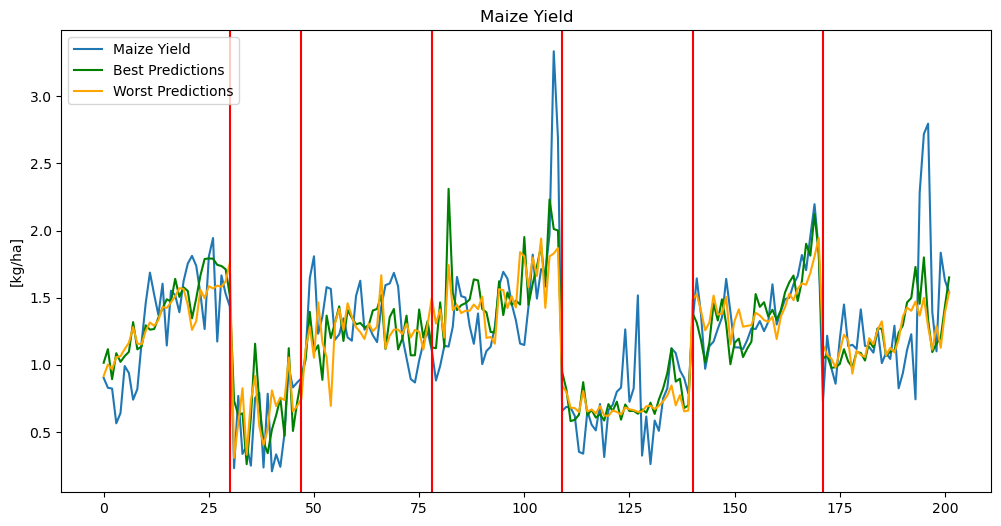

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
#ax.set_xlabel('Year')
ax.set_ylabel('[kg/ha]');
#ax.set_xticklabels(crop_yield_df.index, rotation=70)
#ax.grid(True, which='both')
maize_yield = crop_yield_df['Maize [hg/ha]'] / 10000 
pd_maize_yield, = plt.plot(maize_yield, label='Maize Yield')
pd_predictions_best, = plt.plot(model_sample_best, label='Best Predictions', color='green')
pd_predictions_worst, = plt.plot(model_sample_worst, label='Worst Predictions', color='orange')
plt.legend(handles=[pd_maize_yield, pd_predictions_best, pd_predictions_worst], loc='upper left')
plt.axvline(x = 30, color = 'red', label = '2010') # Burkina Faso
plt.axvline(x = 47, color = 'red', label = '2010') # Eritrea
plt.axvline(x = 78, color = 'red', label = '2010') # Gambia
plt.axvline(x = 109, color = 'red', label = '2010') # Mali
plt.axvline(x = 140, color = 'red', label = '2010') # Niger
plt.axvline(x = 171, color = 'red', label = '2010') # Nigeria

## Cross-validation

In [39]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(mlp_model, X_train, y_train, cv=10)
score

array([ 0.31998935,  0.51601857, -1.54444339,  0.70414771,  0.28665759,
        0.37754195,  0.33499559,  0.3434329 ,  0.24150791,  0.43622424])

In [40]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(mlp_model, X_train, y_train, cv=10)
y_pred.shape

(181,)

In [41]:
y_train[:, 0].shape

(181,)

We can plot the cross-validated predictions against the target values (maize yield). See the scikit-learn [example code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py). 

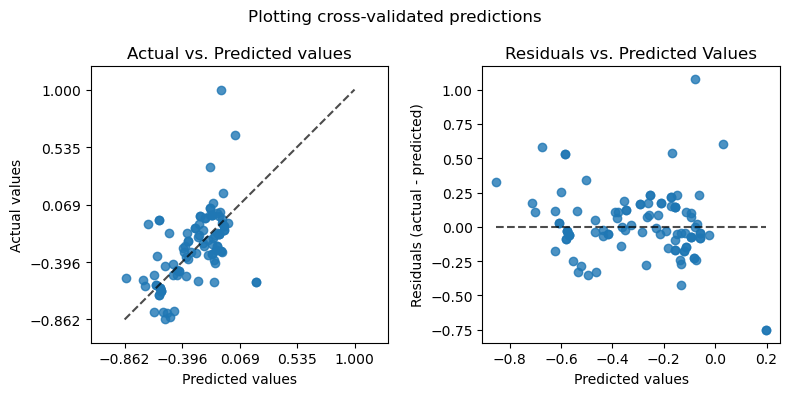

In [42]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

PredictionErrorDisplay.from_predictions(
    y_train[:, 0],
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train[:, 0],
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

## References
* [Pasini et al. - Influence of Meteo-Climatic Variables and Fertilizer Use on Crop Yields in the Sahel: A Nonlinear Neural-Network Analysis](https://www.mdpi.com/2225-1154/10/12/193)
* [Pasini - Artificial neural network for small dataset analysis](https://jtd.amegroups.org/article/view/4418/4811)
* [LeCun et al. - Efficient BackProp](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf)
* [Bengio - Practical Recommendations for Gradient-Based Training of Deep Architectures](https://arxiv.org/abs/1206.5533)
* [Nocedal - Numerical Optimization, 2nd Ed.](https://link.springer.com/book/10.1007/978-0-387-40065-5)
* [Breiman - Bagging Predictors](https://link.springer.com/article/10.1007/BF00058655)
* [Dietterich - Ensemble Methods in Machine Learning](https://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf)
* [Hansen et al. - Neural Network Esembles](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=58871)
* [Buitinck et al. - API design for machine learning software: experiences from scikit-learn project](https://arxiv.org/abs/1309.0238)
* [Raschka - Machine Learning with PyTorch and Scikit-Learn](https://sebastianraschka.com/blog/2022/ml-pytorch-book.html)
* [Molnar - Interpretable Machine Learning - A Guide for Making Black Box Model Explainable](https://christophm.github.io/interpretable-ml-book/)